In [1]:
! pip install -q keras

In [5]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
from tqdm import tqdm
import pickle
import scipy.ndimage.interpolation as inter
from scipy.signal import medfilt 
from scipy.spatial.distance import cdist

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
# from keras.layers.core import *
# from tensorflow.keras.callbacks import *
# from keras.layers.convolutional import *
from keras import backend as K
import keras
import tensorflow as tf



In [6]:
random.seed(1234)

# Configuration class
class Config:
    def __init__(self):
        self.frame_l = 64  # Updated frame length
        self.joint_n = 22  # Number of joints
        self.joint_d = 3   # Dimension of joints
        self.clc_coarse = 14  # Number of coarse classes
        self.clc_fine = 28    # Number of fine-grained classes
        self.feat_d = 231
        self.filters = 64

# Create an instance of Config
C = Config()

In [7]:
from PIL import ImageEnhance

# Update configurations and preprocessing

def updated_sampling_frame(p, C, crop_size_ratio=0.95, zoom_range=(0.9, 1.1), rotation_range=(-15, 15),
                           brightness_range=(0.8, 1.2), contrast_range=(0.8, 1.2)):
    """
    Updated sampling frame function with additional preprocessing steps: random crop, zoom, rotation,
    and brightness/contrast adjustments.

    Args:
        p: Input pose data (numpy array).
        C: Configuration class instance.
        crop_size_ratio: Proportion of the original image to crop.
        zoom_range: Tuple for random zoom range.
        rotation_range: Tuple for random rotation angle range.
        brightness_range: Tuple for random brightness adjustment range.
        contrast_range: Tuple for random contrast adjustment range.
    """
    width, height = C.joint_n, C.frame_l  # Assuming width and height as joints and frames (pose dimensions)
    crop_width, crop_height = int(width * crop_size_ratio), int(height * crop_size_ratio)
    left = random.randint(0, width - crop_width)
    top = random.randint(0, height - crop_height)

    # Crop the pose data (simulate random cropping in an image-like manner)
    cropped_pose = p[top:top + crop_height, left:left + crop_width, :]

    # Zooming by resizing with a random scale factor
    zoom_factor = random.uniform(*zoom_range)
    zoom_width, zoom_height = int(crop_width * zoom_factor), int(crop_height * zoom_factor)
    zoomed_pose = cv2.resize(cropped_pose, (zoom_width, zoom_height), interpolation=cv2.INTER_LINEAR)

    # Rescale back to original dimensions
    resized_pose = cv2.resize(zoomed_pose, (width, height), interpolation=cv2.INTER_LINEAR)

    # Simulate random rotation (pose augmentation)
    rotation_angle = random.uniform(*rotation_range)
    rotation_matrix = cv2.getRotationMatrix2D((width // 2, height // 2), rotation_angle, 1)
    rotated_pose = cv2.warpAffine(resized_pose, rotation_matrix, (width, height))

    # Simulate brightness and contrast adjustments on pose data
    brightness_factor = random.uniform(*brightness_range)
    contrast_factor = random.uniform(*contrast_range)
    adjusted_pose = np.clip(rotated_pose * contrast_factor + brightness_factor, 0, 255)

    return adjusted_pose


# Integrate updated preprocessing in the training dataset loading
def preprocess_dataset(data, C, crop_size_ratio, zoom_range, rotation_range, brightness_range, contrast_range):
    processed_X_0, processed_X_1, processed_Y = [], [], []
    for i in tqdm(range(len(data['pose']))):
        p = np.copy(data['pose'][i]).reshape([-1, C.joint_n, C.joint_d])
        p = updated_sampling_frame(
            p, C, crop_size_ratio, zoom_range, rotation_range, brightness_range, contrast_range
        )
        p = normlize_range(p)  # Normalize the processed data

        label = np.zeros(C.clc_coarse)
        label[data['coarse_label'][i] - 1] = 1

        M = get_CG(p, C)  # Compute the contact graph

        processed_X_0.append(M)
        processed_X_1.append(p)
        processed_Y.append(label)

    return np.stack(processed_X_0), np.stack(processed_X_1), np.stack(processed_Y)

In [8]:
# Temple resizing function
import numpy as np
import os
import pandas as pd
import random
import scipy.ndimage.interpolation as inter
from scipy.signal import medfilt 

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

###################################################################################
    
    
#Rescale to be 64 frames
def zoom(p,target_l=64,joints_num=25,joints_dim=3):
    l = p.shape[0]
    p_new = np.empty([target_l,joints_num,joints_dim]) 
    for m in range(joints_num):
        for n in range(joints_dim):
            p[:,m,n] = medfilt(p[:,m,n],3)
            p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]         
    return p_new

def sampling_frame(p,C):
    full_l = p.shape[0] # full length
    if random.uniform(0,1)<0.5: # aligment sampling
        valid_l = np.round(np.random.uniform(0.9,1)*full_l)
        s = random.randint(0, full_l-int(valid_l))
        e = s+valid_l # sample end point
        p = p[int(s):int(e),:,:]    
    else: # without aligment sampling
        valid_l = np.round(np.random.uniform(0.9,1)*full_l)
        index = np.sort(np.random.choice(range(0,full_l),int(valid_l),replace=False))
        p = p[index,:,:]
    p = zoom(p,C.frame_l,C.joint_n,C.joint_d)
    return p

from scipy.spatial.distance import cdist
def get_CG(p,C):
    M = []
    iu = np.triu_indices(C.joint_n,1,C.joint_n)
    for f in range(C.frame_l):
        #distance max 
        d_m = cdist(p[f],np.concatenate([p[f],np.zeros([1,C.joint_d])]),'euclidean')       
        d_m = d_m[iu] 
        M.append(d_m)
    M = np.stack(M)   
    return M

def normlize_range(p):
    # normolize to start point, use the center for hand case
    p[:,:,0] = p[:,:,0]-np.mean(p[:,:,0])
    p[:,:,1] = p[:,:,1]-np.mean(p[:,:,1])
    p[:,:,2] = p[:,:,2]-np.mean(p[:,:,2])
    return p

def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(8,8)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                #annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
                annot[i, j] = '%.1f' % (p)
            elif c == 0:
                annot[i, j] = ''
            else:
                #annot[i, j] = '%.1f%%\n%d' % (p, c)
                annot[i, j] = '%.1f' % (p)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cbar=False, cmap="YlGnBu")
    plt.savefig(filename)

In [3]:

def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize(x,size=[H,W]) 
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)


def build_DD_Net(frame_l=32,joint_n=22,joint_d=3,feat_d=231,clc_num=14,filters=16):
    M = Input(name='M', shape=(frame_l,feat_d))  
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) 
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [9]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_coarse,C.filters)
DD_Net.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ M (InputLayer)      │ (None, 64, 231)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ P (InputLayer)      │ (None, 64, 22, 3) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 8, 512)    │  1,740,160 │ M[0][0], P[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ functional_1[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     65,536 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_15      │ (None, 128)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ leaky_re_lu_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,384 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_16      │ (None, 128)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ leaky_re_lu_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 14)        │      1,806 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,824,910 (6.96 MB)

 Trainable params: 1,819,278 (6.94 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [10]:
!wget https://github.com/fandulu/DD-Net/archive/master.zip
!unzip master.zip
!rm master.zip

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-12-11 23:27:05--  https://github.com/fandulu/DD-Net/archive/master.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/fandulu/DD-Net/zip/refs/heads/master [following]
--2024-12-11 23:27:05--  https://codeload.github.com/fandulu/DD-Net/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: 'master.zip'

master.zip              [             <=>    ]  79.09M  14.1MB/s    in 5.6s    

2024-12-11 23:27:11 (14.1 MB/s) - 'master.zip' saved [82934337]

Archive:  master.zip
f26a9994b0bafc41096fa269eab89c2757d71499
   creating: DD-Net-master/
  inflating: DD-Net-master/.gitignore  
   creating: DD-Net-master/JHMDB/

In [12]:
Train = pickle.load(open("/kaggle/working/DD-Net-master/data/SHREC/train.pkl", "rb"))
Test = pickle.load(open("/kaggle/working/DD-Net-master/data/SHREC/test.pkl", "rb"))

In [13]:
def preprocess_training_data_with_augmentation(
    data, C, num_augmented_versions=3, crop_size_ratio=0.95, zoom_range=(0.9, 1.1),
    rotation_range=(-15, 15), brightness_range=(0.8, 1.2), contrast_range=(0.8, 1.2)
):
    """
    Preprocess the training data to include the original data and generate multiple augmented versions of each sample.

    Args:
        data: The dataset to preprocess (e.g., Train or Test dictionary).
        C: Configuration object with parameters for preprocessing.
        num_augmented_versions: Number of augmented versions to generate per sample.
        crop_size_ratio: Proportion of the image to crop.
        zoom_range: Range of random zoom factors.
        rotation_range: Range of random rotation angles.
        brightness_range: Range of random brightness adjustments.
        contrast_range: Range of random contrast adjustments.

    Returns:
        X_0: Contact graph features.
        X_1: Preprocessed pose data.
        Y: One-hot encoded labels.
    """
    print(f"Original data size: {len(data['pose'])} samples")

    X_0, X_1, Y = [], [], []

    for i in tqdm(range(len(data['pose']))):
        # Add the original data
        p = np.copy(data['pose'][i]).reshape([-1, C.joint_n, C.joint_d])
        p = normlize_range(p)  # Normalize the original data
        if p.shape[0] != C.frame_l:
            p = zoom(p, target_l=C.frame_l, joints_num=C.joint_n, joints_dim=C.joint_d)  # Ensure correct shape
        label = np.zeros(C.clc_coarse)
        label[data['coarse_label'][i] - 1] = 1
        M = get_CG(p, C)  # Compute contact graph
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

        # Generate augmented versions
        for _ in range(num_augmented_versions):
            p_augmented = np.copy(data['pose'][i]).reshape([-1, C.joint_n, C.joint_d])
            p_augmented = updated_sampling_frame(
                p_augmented, C, crop_size_ratio, zoom_range, rotation_range, brightness_range, contrast_range
            )
            if p_augmented.shape[0] != C.frame_l:
                p_augmented = zoom(p_augmented, target_l=C.frame_l, joints_num=C.joint_n, joints_dim=C.joint_d)
            p_augmented = normlize_range(p_augmented)
            M_augmented = get_CG(p_augmented, C)
            X_0.append(M_augmented)
            X_1.append(p_augmented)
            Y.append(label)  # Same label for augmentations

    print(f"Processed data sizes: X_0={len(X_0)}, X_1={len(X_1)}, Y={len(Y)}")
    return np.stack(X_0), np.stack(X_1), np.stack(Y)

  
# preprocessing for training data
X_0, X_1, Y = preprocess_training_data_with_augmentation(
    Train, C, num_augmented_versions=3, crop_size_ratio=0.95, 
              zoom_range=(0.9, 1.1), rotation_range=(-15, 15), 
              brightness_range=(0.8, 1.2), contrast_range=(0.8, 1.2)
)

Original data size: 1960 samples


  0%|          | 0/1960 [00:00<?, ?it/s]/tmp/ipykernel_23/3227346658.py:23: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
100%|██████████| 1960/1960 [00:28<00:00, 68.99it/s]


Processed data sizes: X_0=7840, X_1=7840, Y=7840


In [14]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

  0%|          | 0/840 [00:00<?, ?it/s]/tmp/ipykernel_23/3227346658.py:23: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]
100%|██████████| 840/840 [00:09<00:00, 91.34it/s]


In [15]:
# it may takes several times to reach the reported performance
lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=400,
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=500,
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Epoch 1/400


I0000 00:00:1733959757.925513     112 service.cc:145] XLA service 0x7e12180089a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733959757.925565     112 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733959757.925569     112 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-12-11 23:29:43.869338: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[7840,512,1,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[7840,512,1,8]{3,2,1,0}, f32[512,512,1,3]{3,2,1,0}), window={size=1x3 pad=0_0x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-11 23:29:44.670669: E external/local_xla/xla

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72s/step - accuracy: 0.0724 - loss: 3.3614

2024-12-11 23:30:23.651536: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[840,128,1,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[840,231,1,64]{3,2,1,0}, f32[128,231,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-11 23:30:24.016954: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.365525069s
Trying algorithm eng3{k11=2} for conv (f32[840,128,1,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[840,231,1,64]{3,2,1,0}, f32[128,231,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_res

1/1 ━━━━━━━━━━━━━━━━━━━━ 79s 79s/step - accuracy: 0.0724 - loss: 3.3614 - val_accuracy: 0.0679 - val_loss: 2.6388 - learning_rate: 1.0000e-04
Epoch 2/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0695 - loss: 3.3536 - val_accuracy: 0.0774 - val_loss: 2.6386 - learning_rate: 1.0000e-04
Epoch 3/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0744 - loss: 3.3196 - val_accuracy: 0.0810 - val_loss: 2.6385 - learning_rate: 1.0000e-04
Epoch 4/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0760 - loss: 3.2897 - val_accuracy: 0.0810 - val_loss: 2.6384 - learning_rate: 1.0000e-04
Epoch 5/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0754 - loss: 3.2578 - val_accuracy: 0.0810 - val_loss: 2.6384 - learning_rate: 1.0000e-04
Epoch 6/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0807 - loss: 3.2568 - val_accuracy: 0.0810 - val_loss: 2.6385 - learning_rate: 1.0000e-04
Epoch 7/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0816 - loss: 3.2146 - val_accuracy: 

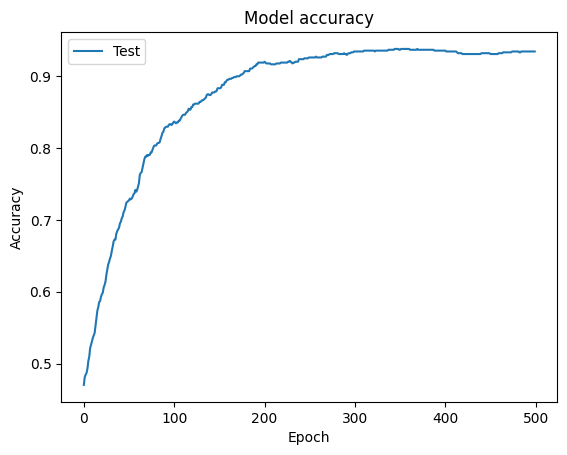

In [16]:
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test'])
plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step


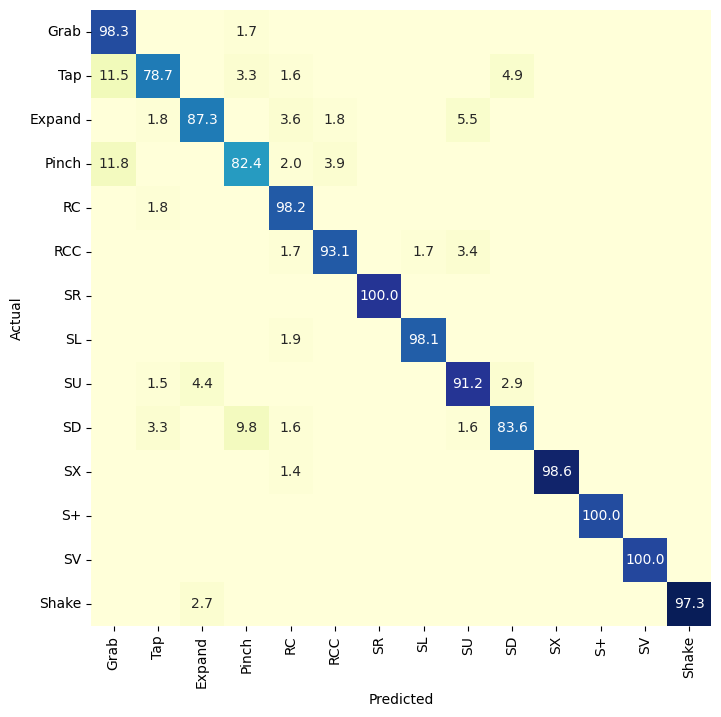

In [17]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['Grab', 'Tap', 'Expand', 'Pinch', 'RC', 'RCC', 'SR', 'SL', 'SU', 'SD', 'SX', 'S+', 'SV', 'Shake']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

cm_analysis(y_true,y_pred, 'SHREC_14.png', labels, ymap=None, figsize=(8,8))